In [1]:
# Import
# Basic
import numpy as np
import random
from IPython.display import Image

# Dataframes + Geo
import geocoder
import pandas as pd      
import geopandas as gpd  
from pyproj import CRS   #coordinate reference system
from shapely.geometry import Point, LineString, Polygon, shape

# Plotting
import hvplot.pandas 
import matplotlib.pyplot as plt

# Gurobi
import gurobipy as gp
from gurobipy import GRB

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Input node data
# GeoDataFrame with lat/long of locations+names

location = ["Gropgårdsgatan", "Lundby gamla kyrka", "D-gate", "visitors parking", "Main entrance", "Centro", "Eketrägatan"]
coordinates = [Point(11.918427908216474, 57.7183407674028), 
                             Point(11.915936139555802,57.712820875276215), 
                             Point(11.916220581869256,57.715438184755826), 
                             Point(11.912020829644117,57.71607853954661), 
                             Point(11.91513083183921, 57.71497749815334), 
                             Point(11.912486306939213, 57.71581079558422), 
                             Point(11.910295299865316, 57.716322252081966)]

nodes_df = gpd.GeoDataFrame(geometry=coordinates, index=location, crs='EPSG:4326') 

# CRS
nodes_df.to_crs("EPSG:3009",inplace=True) #project onto metric [m] coordinate system

# Other
nodes_df["type"] = ["start", "customer", "customer", "customer", "customer", "customer", "end"] #type of node
nodes_df["color"] = ["green", "blue", "blue", "blue", "blue", "blue", "red"] #color of node

lines_df = []
for i, loc_i in enumerate(nodes_df.index.tolist()):
    for j, loc_j in enumerate(nodes_df.index.tolist()):
        if i < j:
            coor = (nodes_df.geometry[loc_i], nodes_df.geometry[loc_j])
            lines_df.append(LineString(coor))
lines_df = gpd.GeoDataFrame(geometry=lines_df, crs='EPSG:3009') 
nodes_df["demand"] = [0, 10, 10, 5, 3, 4, 0]

In [3]:
# Create distance/cost DataFrame

# Get (rounded) Euclidian distance matrix from coordinates [m] 
distance_df = pd.DataFrame(columns=nodes_df.index, index=nodes_df.index)
for i in nodes_df.index:
    for j in nodes_df.index:
        distance_df.loc[i,j] = round(nodes_df.loc[i,'geometry'].distance(nodes_df.loc[j,'geometry']))
distance_df.astype(float);

# Project

### General conditions and constraints
* one truck with:
     * max capacity $K$
     * max driving distance $L$ (treated as equivalent to the limitation on distribution cost)
* customers $i \in \mathcal{B} = \{1,...,n-1\}$ with demand $d_i$
* start and end-point for route $\rightarrow$ total set of nodes: $ \mathcal{N} = \mathcal{B} \cup \{0,n\} = \{0,...,n\}$
* not all customers must be visited, but if a customer is visited <b>all</b> of their
demand must be satisfied
* Euclidian distance between two nodes $c_{ij}$ (treated as equvalent to the cost of driving between two locations)


In [5]:
nodes_df.hvplot.points(geo=True,crs="EPSG:3009", tiles='CartoLight', hover_cols=["index","type","demand"], 
                color="color", size=((nodes_df["demand"]+3)*3)**2, width=500, height=500, title="CampX")*\
lines_df.hvplot(geo=True, crs="EPSG:3009")

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (color,_size,index,type,demand)
   .Path.I   :Path   [Longitude,Latitude]

### Assumptions
* Euclidean distance - but more importantly: all $c_{ij}$ satisfy the triangle inequality ($c_{ij} \leq c_{ik} + c_{kj}$). This can be ensured with pre-processing.
* distribution cost $\propto$ driving distance
* delivery profit $\propto$ items delivered

### Objective: maximize profit made from deliveries.
With the assumption that <i>delivery profit $\propto$ items delivered</i>, we have that:
$$\text{max \{profit made from deliveries \} = min \{unused capacity\}}$$
\
note: the distribution cost is not included in the objective. This means that our result will not - in general - be the most profitable route, when $$\text{profit = profit from deliveries - cost of distribution}$$

## Model

Parameters
* $K$ : max capacity
* $L$ : max travel distance
* $c_{ij}$ : cost of arc $(i,j) \in \mathcal{A}$
* $d_i$ : demand of customer $i \in \mathcal{B}$

Variables
* $y_{ij} = \begin{cases}1 & \text{if arc $(i,j)$ is used}, \\ 0 & \text{else}\end{cases}$ 
* $x_i \geq 0 $ tracks the order to visit the customers by setting $x_j \geq x_i + 1$, $ \text{ if } y_{ij} = 1 \textit{, } (i,j) \in \mathcal{A}.$
* $s_K \geq 0$: slack variable for unused capacity
* $s_L \geq 0$: slack variable for unused travel distance

## MILP formulation

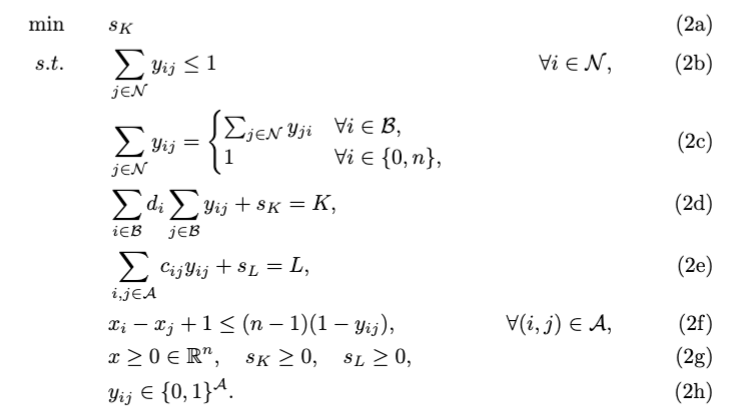

In [6]:
# Display MILP
display(Image(filename='volvo_int2_model.png'))

### Constructing the model
* Ensure total distance traveled does not exceed $L$: $$ \sum_{i,j\in \mathcal{A}}c_{ij}y_{ij} + s_L = L, $$
* Ensure that if the route goes <b>to</b> a customer it also has to <b>leave</b> said customer: $$ \sum_{j\in \mathcal{N}}y_{ij} = \begin{cases}
            \sum_{j\in \mathcal{N}}y_{ji} & \forall i\in \mathcal{B}, \\
            1 & \forall i \in \{0,n\},
            \end{cases} $$ note the special case for start- and end-nodes.
* Since we are already keeping track of if an arc is being used, we can use the same variables to see if a node is being visited, i.e., a customer is visited if $$ \sum_{j\in \mathcal{N}}y_{ij} = \sum_{i\in \mathcal{N}}y_{ij} = 1, $$ and we can (for example) ensure that the number of deliveries made does not exceed capacity using: $$ \sum_{i\in \mathcal{B}}d_i\sum_{j\in \mathcal{B}}y_{ij} + s_K = K. $$ This was the reason for including constraint (2b) - to avoid allowing for multiple visits (and counting those visits as deliveries). Constraint (2b), however, can be removed since this is ensured by constraint (2c) together with (2f).
* We use the "counter"-variables $x_i$ to ensure the route contains no cycles. This will ensure that the final route is connected. Constraint (2f) is just a rewriting of $$ x_j \geq x_i + 1, \quad \text{ if } \quad y_{ij} = 1 \textit{, } (i,j) \in \mathcal{A},$$ since constraint (2f) only is active when $y_{ij} = 1$.

# Some different cases

## Case 1.a - distribution cost
We show that this formulation will not neccessarily find the optimal solution re: cost of transport
* Allowing for very high transport cost (C >>) means the only real restriction is capacity (K)
* Since K = sum(d_i)-1 skipping either "Centro" or "D-gate" (both with demand 1) would provide an optimal solution
* But clearly no incentive to "drive smart"
* Suggestion: add small incentive (penalty) to objective function for each [m] distance travelled

In [7]:
# Assign demand
nodes_df["demand"] = [0,3,1,2,5,1,0]  

# Max capacity: one less than total demand
K = sum(nodes_df["demand"]) - 1

# Max transport cost: in practice no limitation
L = 5000

eps = 0.00001 
epsilon_penalty = False 

In [8]:
# Solve 1a

# Indexing
nodes = [i for i in nodes_df.index.tolist()]
start = nodes[0]
end = nodes[-1]
N = len(nodes)

arcs = [(i,j) for i in nodes[0:-1] for j in nodes[1::] if i!=j] # exclude the possibility of returning to "start" node,
                                                                # as well as leaving "end" node
                                                                # also skip (i,i)

C_ij = {} #distance/cost of arc i,j
for arc in arcs:
    c_ij = distance_df[arc[0]][arc[1]] #length of arc
    C_ij[arc] = c_ij

    
D_i = {} #demand/profit of node i
for node in nodes:
    d_i = nodes_df["demand"][node]
    D_i[node] = d_i

#model
try:
    m = gp.Model("Transport")
    
    # Create variables
    y = m.addVars(arcs, vtype=GRB.BINARY, name="Y") # if arc (i,j) is used
    y_help = m.addVars(nodes, name="YHelp")         # helper variable y_help = y.sum(i,"*") for i in nodes
    s_K = m.addVar(name="SK")                       # slack - capacity
    s_L = m.addVar(name="SL")                       # slack - distance 
    x = m.addVars(nodes, name="X")                  # visitation-order
    
    eps = 0.00001 

    
    # (a) Objective function 
    if epsilon_penalty:
        obj = s_K  - eps*s_L
    else:
        obj = s_K 
    m.setObjective(obj, GRB.MINIMIZE)

    # Constraints
    
    # (b) Visit each node max once 
    m.addConstrs((y.sum(i,"*") <= 1 for i in nodes), "B") 

    # (c).i) If you go *to* a customer, you must *leave* said customer
    m.addConstrs((y.sum(i,"*") == y.sum("*",i) for i in nodes[1:-1]), "Ca")
    # (c).ii)  You may only leave "start" by one route, and arrive at "end" by one route
    m.addConstr((y.sum(start,"*") == 1), "Cb")
    m.addConstr((y.sum("*",end) == 1), "Cc")

    # (d) Capacity constraint
    m.addConstrs((y_help[i] == y.sum(i,"*") for i in nodes), "D_help")
    m.addConstr((y_help.prod(D_i) + s_K == K), "D")

    # (e) Distance constraint
    m.addConstr((y.prod(C_ij) + s_L == L), "E")
    
    # (f) Order of visitation + no cycles
    m.addConstrs((x[i]-x[j] + 1 <= (N-1)*(1-y[i,j]) for (i,j) in arcs),"F")


    
    m.optimize()
    #for vars in m.getVars():
    #    print('%s %g' % (vars.VarName, v.X))
    
    print('Obj: %g' % m.ObjVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-15
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 54 rows, 47 columns and 262 nonzeros
Model fingerprint: 0x381b2e0e
Variable types: 16 continuous, 31 integer (31 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03]
Found heuristic solution: objective 11.0000000
Presolve removed 16 rows and 6 columns
Presolve time: 0.00s
Presolved: 38 rows, 41 columns, 167 nonzeros
Variable types: 5 continuous, 36 integer (36 binary)

Root relaxation: objective -1.776357e-15, 23 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node T

In [9]:
# Plot 1a
dic = m.getAttr("X", y)
lines_df = []
points_df = []
for arc in arcs: 
    if dic[arc] == 1:
        coor = (nodes_df.geometry[arc[0]], nodes_df.geometry[arc[1]])
        lines_df.append(LineString(coor))
        points_df.append(coor[0])
lines_df = gpd.GeoDataFrame(geometry=lines_df, crs='EPSG:3009') 
points_df = gpd.GeoDataFrame(geometry=points_df, crs='EPSG:3009') 

nodes_df.hvplot.points(geo=True,crs="EPSG:3009", tiles='CartoLight', hover_cols=["index","type","demand"], 
                color="color", size=((nodes_df["demand"]+3)*3)**2, width=500, height=500)*\
lines_df.hvplot(geo=True, crs="EPSG:3009")*\
points_df.hvplot(geo=True, crs="EPSG:3009", color="red")

:Overlay
   .WMTS.I    :WMTS   [Longitude,Latitude]
   .Points.I  :Points   [Longitude,Latitude]   (color,_size,index,type,demand)
   .Path.I    :Path   [Longitude,Latitude]
   .Points.II :Points   [Longitude,Latitude]

## Case 1.b - traveling salesman
Increasing K by one, with $\varepsilon$-penalty added, gives classic traveling salesman \
(result: the minimum distance needed to traverse all nodes is: 1216 [m])

In [10]:
# Assign demand
nodes_df["demand"] = [0,3,1,2,5,1,0]  

# Max capacity: can handle all customers
K = sum(nodes_df["demand"]) 

# Max transport cost: in practice no limitation
L = 5000

epsilon_penalty = False 


In [11]:
# Solve 1b

# Indexing
nodes = [i for i in nodes_df.index.tolist()]
start = nodes[0]
end = nodes[-1]
N = len(nodes)

arcs = [(i,j) for i in nodes[0:-1] for j in nodes[1::] if i!=j] # exclude the possibility of returning to "start" node,
                                                                # as well as leaving "end" node
                                                                # also skip (i,i)

C_ij = {} #distance/cost of arc i,j
for arc in arcs:
    c_ij = distance_df[arc[0]][arc[1]] #length of arc
    C_ij[arc] = c_ij

    
D_i = {} #demand/profit of node i
for node in nodes:
    d_i = nodes_df["demand"][node]
    D_i[node] = d_i

#model
try:
    m = gp.Model("Transport")
    
    # Create variables
    y = m.addVars(arcs, vtype=GRB.BINARY, name="Y") # if arc (i,j) is used
    y_help = m.addVars(nodes, name="YHelp")         # helper variable y_help = y.sum(i,"*") for i in nodes
    s_K = m.addVar(name="SK")                       # slack - capacity
    s_L = m.addVar(name="SL")                       # slack - distance 
    x = m.addVars(nodes, name="X")                  # visitation-order
    
    eps = 0.00001 

    
    # (a) Objective function 
    if epsilon_penalty:
        obj = s_K  - eps*s_L
    else:
        obj = s_K 
    m.setObjective(obj, GRB.MINIMIZE)

    # Constraints
    
    # (b) Visit each node max once 
    m.addConstrs((y.sum(i,"*") <= 1 for i in nodes), "B") 

    # (c).i) If you go *to* a customer, you must *leave* said customer
    m.addConstrs((y.sum(i,"*") == y.sum("*",i) for i in nodes[1:-1]), "Ca")
    # (c).ii)  You may only leave "start" by one route, and arrive at "end" by one route
    m.addConstr((y.sum(start,"*") == 1), "Cb")
    m.addConstr((y.sum("*",end) == 1), "Cc")

    # (d) Capacity constraint
    m.addConstrs((y_help[i] == y.sum(i,"*") for i in nodes), "D_help")
    m.addConstr((y_help.prod(D_i) + s_K == K), "D")

    # (e) Distance constraint
    m.addConstr((y.prod(C_ij) + s_L == L), "E")
    
    # (f) Order of visitation + no cycles
    m.addConstrs((x[i]-x[j] + 1 <= (N-1)*(1-y[i,j]) for (i,j) in arcs),"F")


    
    m.optimize()
    #for vars in m.getVars():
    #    print('%s %g' % (vars.VarName, v.X))
    
    print('Obj: %g' % m.ObjVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 54 rows, 47 columns and 262 nonzeros
Model fingerprint: 0xc0e58ec0
Variable types: 16 continuous, 31 integer (31 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03]
Found heuristic solution: objective 12.0000000
Presolve removed 17 rows and 11 columns
Presolve time: 0.00s
Presolved: 37 rows, 36 columns, 157 nonzeros
Variable types: 5 continuous, 31 integer (31 binary)

Root relaxation: objective 0.000000e+00, 22 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                       0.0000000  -48.00000      -     -    0s
     0     

In [12]:
# Plot 1b
dic = m.getAttr("X", y)
lines_df = []
points_df = []
for arc in arcs: 
    if dic[arc] == 1:
        coor = (nodes_df.geometry[arc[0]], nodes_df.geometry[arc[1]])
        lines_df.append(LineString(coor))
        points_df.append(coor[0])
lines_df = gpd.GeoDataFrame(geometry=lines_df, crs='EPSG:3009') 
points_df = gpd.GeoDataFrame(geometry=points_df, crs='EPSG:3009') 

nodes_df.hvplot.points(geo=True,crs="EPSG:3009", tiles='CartoLight', hover_cols=["index","type","demand"], 
                color="color", size=((nodes_df["demand"]+3)*3)**2, width=500, height=500)*\
lines_df.hvplot(geo=True, crs="EPSG:3009")*\
points_df.hvplot(geo=True, crs="EPSG:3009", color="red")

:Overlay
   .WMTS.I    :WMTS   [Longitude,Latitude]
   .Points.I  :Points   [Longitude,Latitude]   (color,_size,index,type,demand)
   .Path.I    :Path   [Longitude,Latitude]
   .Points.II :Points   [Longitude,Latitude]

## Case 2:
K < min(d_i) for all reachable nodes i --> traveling straight from start to end \
In this case "Lundby gamla kyrka" is the only node with d_i <= K, but L is chosen s.t. "Lundby gamla kyrka" is unreachable

In [13]:
# Assign demand
nodes_df["demand"] = [0,1,5,5,5,5,0]  

# Max capacity: only feasible customer to pass is Lundby gamla kyrka
K = 2

# Max transport cost: We cannot go to Lundby gamla kyrka
L = distance_df["Gropgårdsgatan"]["Lundby gamla kyrka"] + distance_df["Lundby gamla kyrka"]["Eketrägatan"] - 1

epsilon_penalty = False 

In [14]:
# Solve 2

# Indexing
nodes = [i for i in nodes_df.index.tolist()]
start = nodes[0]
end = nodes[-1]
N = len(nodes)

arcs = [(i,j) for i in nodes[0:-1] for j in nodes[1::] if i!=j] # exclude the possibility of returning to "start" node,
                                                                # as well as leaving "end" node
                                                                # also skip (i,i)

C_ij = {} #distance/cost of arc i,j
for arc in arcs:
    c_ij = distance_df[arc[0]][arc[1]] #length of arc
    C_ij[arc] = c_ij

    
D_i = {} #demand/profit of node i
for node in nodes:
    d_i = nodes_df["demand"][node]
    D_i[node] = d_i

#model
try:
    m = gp.Model("Transport")
    
    # Create variables
    y = m.addVars(arcs, vtype=GRB.BINARY, name="Y") # if arc (i,j) is used
    y_help = m.addVars(nodes, name="YHelp")         # helper variable y_help = y.sum(i,"*") for i in nodes
    s_K = m.addVar(name="SK")                       # slack - capacity
    s_L = m.addVar(name="SL")                       # slack - distance 
    x = m.addVars(nodes, name="X")                  # visitation-order
    
    eps = 0.00001 

    
    # (a) Objective function 
    if epsilon_penalty:
        obj = s_K  - eps*s_L
    else:
        obj = s_K 
    m.setObjective(obj, GRB.MINIMIZE)

    # Constraints
    
    # (b) Visit each node max once 
    m.addConstrs((y.sum(i,"*") <= 1 for i in nodes), "B") 

    # (c).i) If you go *to* a customer, you must *leave* said customer
    m.addConstrs((y.sum(i,"*") == y.sum("*",i) for i in nodes[1:-1]), "Ca")
    # (c).ii)  You may only leave "start" by one route, and arrive at "end" by one route
    m.addConstr((y.sum(start,"*") == 1), "Cb")
    m.addConstr((y.sum("*",end) == 1), "Cc")

    # (d) Capacity constraint
    m.addConstrs((y_help[i] == y.sum(i,"*") for i in nodes), "D_help")
    m.addConstr((y_help.prod(D_i) + s_K == K), "D")

    # (e) Distance constraint
    m.addConstr((y.prod(C_ij) + s_L == L), "E")
    
    # (f) Order of visitation + no cycles
    m.addConstrs((x[i]-x[j] + 1 <= (N-1)*(1-y[i,j]) for (i,j) in arcs),"F")


    
    m.optimize()
    #for vars in m.getVars():
    #    print('%s %g' % (vars.VarName, v.X))
    
    print('Obj: %g' % m.ObjVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 54 rows, 47 columns and 262 nonzeros
Model fingerprint: 0xd9d7e1d8
Variable types: 16 continuous, 31 integer (31 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 2.0000000
Presolve removed 54 rows and 47 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 2 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.000000000000e+00, best bound 2.000000000000e+00, gap 0.0000%
Obj: 2


In [15]:
# Plot 2
dic = m.getAttr("X", y)
lines_df = []
points_df = []
for arc in arcs: 
    if dic[arc] == 1:
        coor = (nodes_df.geometry[arc[0]], nodes_df.geometry[arc[1]])
        lines_df.append(LineString(coor))
        points_df.append(coor[0])
lines_df = gpd.GeoDataFrame(geometry=lines_df, crs='EPSG:3009') 
points_df = gpd.GeoDataFrame(geometry=points_df, crs='EPSG:3009') 

nodes_df.hvplot.points(geo=True,crs="EPSG:3009", tiles='CartoLight', hover_cols=["index","type","demand"], 
                color="color", size=((nodes_df["demand"]+3)*3)**2, width=500, height=500)*\
lines_df.hvplot(geo=True, crs="EPSG:3009")*\
points_df.hvplot(geo=True, crs="EPSG:3009", color="red")

:Overlay
   .WMTS.I    :WMTS   [Longitude,Latitude]
   .Points.I  :Points   [Longitude,Latitude]   (color,_size,index,type,demand)
   .Path.I    :Path   [Longitude,Latitude]
   .Points.II :Points   [Longitude,Latitude]

## Case 3:
Random testing

In [16]:
# Assign demand at random
rand_list = [random.randint(1,10) for x in range(0,5)]
nodes_df["demand"] = [0] + rand_list + [0]  

# Max capacity: at random while s.t: min(d_i) <= K <= sum(d_i)
K = random.randint(min(nodes_df["demand"]),sum(nodes_df["demand"]))

# Max transport cost: at random while s.t: min(c_0i + c_in) <= L <= max distance needed to cover all nodes (see TSP)
min_dist = distance_df["Gropgårdsgatan"]["visitors parking"] + distance_df["visitors parking"]["Eketrägatan"]
max_dist = 1216
L = random.randint(min_dist,max_dist)

epsilon_penalty = False 

In [17]:
# Solve 3

# Indexing
nodes = [i for i in nodes_df.index.tolist()]
start = nodes[0]
end = nodes[-1]
N = len(nodes)

arcs = [(i,j) for i in nodes[0:-1] for j in nodes[1::] if i!=j] # exclude the possibility of returning to "start" node,
                                                                # as well as leaving "end" node
                                                                # also skip (i,i)

C_ij = {} #distance/cost of arc i,j
for arc in arcs:
    c_ij = distance_df[arc[0]][arc[1]] #length of arc
    C_ij[arc] = c_ij

    
D_i = {} #demand/profit of node i
for node in nodes:
    d_i = nodes_df["demand"][node]
    D_i[node] = d_i

#model
try:
    m = gp.Model("Transport")
    
    # Create variables
    y = m.addVars(arcs, vtype=GRB.BINARY, name="Y") # if arc (i,j) is used
    y_help = m.addVars(nodes, name="YHelp")         # helper variable y_help = y.sum(i,"*") for i in nodes
    s_K = m.addVar(name="SK")                       # slack - capacity
    s_L = m.addVar(name="SL")                       # slack - distance 
    x = m.addVars(nodes, name="X")                  # visitation-order
    
    eps = 0.00001 

    
    # (a) Objective function 
    if epsilon_penalty:
        obj = s_K  - eps*s_L
    else:
        obj = s_K 
    m.setObjective(obj, GRB.MINIMIZE)

    # Constraints
    
    # (b) Visit each node max once 
    m.addConstrs((y.sum(i,"*") <= 1 for i in nodes), "B") 

    # (c).i) If you go *to* a customer, you must *leave* said customer
    m.addConstrs((y.sum(i,"*") == y.sum("*",i) for i in nodes[1:-1]), "Ca")
    # (c).ii)  You may only leave "start" by one route, and arrive at "end" by one route
    m.addConstr((y.sum(start,"*") == 1), "Cb")
    m.addConstr((y.sum("*",end) == 1), "Cc")

    # (d) Capacity constraint
    m.addConstrs((y_help[i] == y.sum(i,"*") for i in nodes), "D_help")
    m.addConstr((y_help.prod(D_i) + s_K == K), "D")

    # (e) Distance constraint
    m.addConstr((y.prod(C_ij) + s_L == L), "E")
    
    # (f) Order of visitation + no cycles
    m.addConstrs((x[i]-x[j] + 1 <= (N-1)*(1-y[i,j]) for (i,j) in arcs),"F")


    
    m.optimize()
    #for vars in m.getVars():
    #    print('%s %g' % (vars.VarName, v.X))
    
    print('Obj: %g' % m.ObjVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 54 rows, 47 columns and 262 nonzeros
Model fingerprint: 0xf4ae1d14
Variable types: 16 continuous, 31 integer (31 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 22.0000000
Presolve removed 15 rows and 8 columns
Presolve time: 0.00s
Presolved: 39 rows, 39 columns, 184 nonzeros
Variable types: 5 continuous, 34 integer (34 binary)

Root relaxation: objective 1.428571e-01, 17 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.14286    0    9   22.00000    0.14286  99.4%     -    0s
H    0     0

In [18]:
# Plot 3
dic = m.getAttr("X", y)
lines_df = []
points_df = []
for arc in arcs: 
    if dic[arc] == 1:
        coor = (nodes_df.geometry[arc[0]], nodes_df.geometry[arc[1]])
        lines_df.append(LineString(coor))
        points_df.append(coor[0])
lines_df = gpd.GeoDataFrame(geometry=lines_df, crs='EPSG:3009') 
points_df = gpd.GeoDataFrame(geometry=points_df, crs='EPSG:3009') 

nodes_df.hvplot.points(geo=True,crs="EPSG:3009", tiles='CartoLight', hover_cols=["index","type","demand"], 
                color="color", size=((nodes_df["demand"]+3)*3)**2, width=500, height=500)*\
lines_df.hvplot(geo=True, crs="EPSG:3009")*\
points_df.hvplot(geo=True, crs="EPSG:3009", color="red")

:Overlay
   .WMTS.I    :WMTS   [Longitude,Latitude]
   .Points.I  :Points   [Longitude,Latitude]   (color,_size,index,type,demand)
   .Path.I    :Path   [Longitude,Latitude]
   .Points.II :Points   [Longitude,Latitude]

## Case 4:
Final instance
* K = 24
* L = 1031
* demand = [0, 10, 10, 5, 3, 4, 0]

In [19]:
K =  24
L =  1031
nodes_df["demand"] =  [0, 10, 10, 5, 3, 4, 0]
epsilon_penalty = False 

In [20]:
# Solve 4

# Indexing
nodes = [i for i in nodes_df.index.tolist()]
start = nodes[0]
end = nodes[-1]
N = len(nodes)

arcs = [(i,j) for i in nodes[0:-1] for j in nodes[1::] if i!=j] # exclude the possibility of returning to "start" node,
                                                                # as well as leaving "end" node
                                                                # also skip (i,i)

C_ij = {} #distance/cost of arc i,j
for arc in arcs:
    c_ij = distance_df[arc[0]][arc[1]] #length of arc
    C_ij[arc] = c_ij

    
D_i = {} #demand/profit of node i
for node in nodes:
    d_i = nodes_df["demand"][node]
    D_i[node] = d_i

#model
try:
    m = gp.Model("Transport")
    
    # Create variables
    y = m.addVars(arcs, vtype=GRB.BINARY, name="Y") # if arc (i,j) is used
    y_help = m.addVars(nodes, name="YHelp")         # helper variable y_help = y.sum(i,"*") for i in nodes
    s_K = m.addVar(name="SK")                       # slack - capacity
    s_L = m.addVar(name="SL")                       # slack - distance 
    x = m.addVars(nodes, name="X")                  # visitation-order
    
    eps = 0.00001 

    
    # (a) Objective function 
    if epsilon_penalty:
        obj = s_K  - eps*s_L
    else:
        obj = s_K 
    m.setObjective(obj, GRB.MINIMIZE)

    # Constraints
    
    # (b) Visit each node max once 
    m.addConstrs((y.sum(i,"*") <= 1 for i in nodes), "B") 

    # (c).i) If you go *to* a customer, you must *leave* said customer
    m.addConstrs((y.sum(i,"*") == y.sum("*",i) for i in nodes[1:-1]), "Ca")
    # (c).ii)  You may only leave "start" by one route, and arrive at "end" by one route
    m.addConstr((y.sum(start,"*") == 1), "Cb")
    m.addConstr((y.sum("*",end) == 1), "Cc")

    # (d) Capacity constraint
    m.addConstrs((y_help[i] == y.sum(i,"*") for i in nodes), "D_help")
    m.addConstr((y_help.prod(D_i) + s_K == K), "D")

    # (e) Distance constraint
    m.addConstr((y.prod(C_ij) + s_L == L), "E")
    
    # (f) Order of visitation + no cycles
    m.addConstrs((x[i]-x[j] + 1 <= (N-1)*(1-y[i,j]) for (i,j) in arcs),"F")


    
    m.optimize()
    #for vars in m.getVars():
    #    print('%s %g' % (vars.VarName, v.X))
    
    print('Obj: %g' % m.ObjVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 54 rows, 47 columns and 262 nonzeros
Model fingerprint: 0xd622944c
Variable types: 16 continuous, 31 integer (31 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 24.0000000
Presolve removed 18 rows and 17 columns
Presolve time: 0.00s
Presolved: 36 rows, 30 columns, 147 nonzeros
Variable types: 5 continuous, 25 integer (25 binary)

Root relaxation: objective 2.000000e+00, 13 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.00000    0    7   24.00000    2.00000  91.7%     -    0s
H    0     

In [21]:
# Plot 4
dic = m.getAttr("X", y)
lines_df = []
points_df = []
for arc in arcs: 
    if dic[arc] == 1:
        coor = (nodes_df.geometry[arc[0]], nodes_df.geometry[arc[1]])
        lines_df.append(LineString(coor))
        points_df.append(coor[0])
lines_df = gpd.GeoDataFrame(geometry=lines_df, crs='EPSG:3009') 
points_df = gpd.GeoDataFrame(geometry=points_df, crs='EPSG:3009') 

nodes_df.hvplot.points(geo=True,crs="EPSG:3009", tiles='CartoLight', hover_cols=["index","type","demand"], 
                color="color", size=((nodes_df["demand"]+3)*3)**2, width=500, height=500)*\
lines_df.hvplot(geo=True, crs="EPSG:3009")*\
points_df.hvplot(geo=True, crs="EPSG:3009", color="red")

:Overlay
   .WMTS.I    :WMTS   [Longitude,Latitude]
   .Points.I  :Points   [Longitude,Latitude]   (color,_size,index,type,demand)
   .Path.I    :Path   [Longitude,Latitude]
   .Points.II :Points   [Longitude,Latitude]

## The code
### "Pre-processing"
Define index sets and convert relevant data to dictionaries \
(here we could exclude infeasible nodes if we wanted)

In [22]:
# Indexing
nodes = [i for i in nodes_df.index.tolist()]
start = nodes[0]
end = nodes[-1]
N = len(nodes)

arcs = [(i,j) for i in nodes[0:-1] for j in nodes[1::] if i!=j] # exclude the possibility of returning to "start" node,
                                                                # as well as leaving "end" node
                                                                # also skip (i,i)

C_ij = {} #distance/cost of arc i,j
for arc in arcs:
    c_ij = distance_df[arc[0]][arc[1]] #length of arc
    C_ij[arc] = c_ij

    
D_i = {} #demand/profit of node i
for node in nodes:
    d_i = nodes_df["demand"][node]
    D_i[node] = d_i


In [23]:
#model
try:
    m = gp.Model("Transport")
    
    # Create variables
    y = m.addVars(arcs, vtype=GRB.BINARY, name="Y") # if arc (i,j) is used
    y_help = m.addVars(nodes, name="YHelp")         # helper variable y_help = y.sum(i,"*") for i in nodes
    s_K = m.addVar(name="SK")                       # slack - capacity
    s_L = m.addVar(name="SL")                       # slack - distance 
    x = m.addVars(nodes, name="X")                  # visitation-order
    
    eps = 0.00001 

    # (a) Objective function 
    if epsilon_penalty:
        obj = s_K  - eps*s_L
    else:
        obj = s_K 
    m.setObjective(obj, GRB.MINIMIZE)

    # Constraints
    
    # (b) Visit each node max once 
    m.addConstrs((y.sum(i,"*") <= 1 for i in nodes), "B") 

    # (c).i) If you go *to* a customer, you must *leave* said customer
    m.addConstrs((y.sum(i,"*") == y.sum("*",i) for i in nodes[1:-1]), "Ca")
    # (c).ii)  You may only leave "start" by one route, and arrive at "end" by one route
    m.addConstr((y.sum(start,"*") == 1), "Cb")
    m.addConstr((y.sum("*",end) == 1), "Cc")

    # (d) Capacity constraint
    m.addConstrs((y_help[i] == y.sum(i,"*") for i in nodes), "D_help")
    m.addConstr((y_help.prod(D_i) + s_K == K), "D")

    # (e) Distance constraint
    m.addConstr((y.prod(C_ij) + s_L == L), "E")
    
    # (f) Order of visitation + no cycles
    m.addConstrs((x[i]-x[j] + 1 <= (N-1)*(1-y[i,j]) for (i,j) in arcs),"F")


    
    m.optimize()
    #for vars in m.getVars():
    #    print('%s %g' % (vars.VarName, v.X))
    
    print('Obj: %g' % m.ObjVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 54 rows, 47 columns and 262 nonzeros
Model fingerprint: 0xd622944c
Variable types: 16 continuous, 31 integer (31 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 24.0000000
Presolve removed 18 rows and 17 columns
Presolve time: 0.00s
Presolved: 36 rows, 30 columns, 147 nonzeros
Variable types: 5 continuous, 25 integer (25 binary)

Root relaxation: objective 2.000000e+00, 13 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.00000    0    7   24.00000    2.00000  91.7%     -    0s
H    0     

In [26]:
dic = m.getAttr("X", y)
lines_df = []
points_df = []
for arc in arcs: 
    if dic[arc] == 1:
        coor = (nodes_df.geometry[arc[0]], nodes_df.geometry[arc[1]])
        lines_df.append(LineString(coor))
        points_df.append(coor[0])
lines_df = gpd.GeoDataFrame(geometry=lines_df, crs='EPSG:3009') 
points_df = gpd.GeoDataFrame(geometry=points_df, crs='EPSG:3009') 

nodes_df.hvplot.points(geo=True,crs="EPSG:3009", tiles='CartoLight', hover_cols=["index","type","demand"], 
                color="color", size=((nodes_df["demand"]+3)*3)**2, width=500, height=500)*\
lines_df.hvplot(geo=True, crs="EPSG:3009")*\
points_df.hvplot(geo=True, crs="EPSG:3009", color="red")

:Overlay
   .WMTS.I    :WMTS   [Longitude,Latitude]
   .Points.I  :Points   [Longitude,Latitude]   (color,_size,index,type,demand)
   .Path.I    :Path   [Longitude,Latitude]
   .Points.II :Points   [Longitude,Latitude]

Other variables of interest

In [25]:
# Order
order = m.getAttr("X", x)
for key, val in order.items():
    order[key] = round(val)
order

{'Gropgårdsgatan': 0,
 'Lundby gamla kyrka': 0,
 'D-gate': 2,
 'visitors parking': 4,
 'Main entrance': 1,
 'Centro': 3,
 'Eketrägatan': 5}

In [88]:
# unused travel distance [m]
s_L.getAttr(GRB.Attr.X)

152.0